When dealing with data with dozens or hundreds of features one important tool is to look at the correlations between different features as a heat map. Although it is easy to generate a correlation heat map not all such visualizations are created equal. Here are some rules of thumb to keep in mind, 

* Limit the range of the color map to the middle 99.x% of the values
* Use symmetric magnitude bounds
* Use a divergent color map
* Make 0 correlation correspond to a dull dark color (dark grey), and high magnitude correlations high luminance
* Different orderings of the features can have a huge impact, pick wisely.

Using these guidelines together almost always improves the overall quality of the visualization of a correlation or covariance matrix. 

We will apply these guidelines one by one to an example data set (see below) talking about the motivation for each guideline as we apply it.

<!-- TEASER_END -->

Keep in mind that these are just some general guidelines that represent how I typically like to visualize correlation matrices that works in most situations. However different situations may sometimes call for other choices to be made. In particular these guidelines are only necessary when you start venturing into the realm of tens of features or more. If you are visualizing the relationships between just 3 or 4 columns of features the correlation matrix is not likely to be all that informative. A much better use of your visual bandwidth would be to use a grid of all the possible pairwise scatter plots  (see <a href=https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166> here </a> for some pretty example plots with 3 and 4 features). 


In [1]:
import numpy as np
np.random.seed(1234)

import pandas as pd

import h5py
import scipy
import scipy.cluster
import scipy.ndimage
import matplotlib.pyplot as plt

import sklearn
import sklearn.metrics
import sklearn.mixture
import sklearn.decomposition


In [2]:
%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":15,
        "image.cmap":"viridis",
        "image.aspect":"auto",
        "lines.linewidth":2,
    }
)


# Mystery Data Set.

I have prepared a data set to play around with. I have chosen a data set with a rich correlational structure and enough features to make looking at each possible pair of features one at a time an onerous task but not so many features that the correlation matrix can't be easily visualized all at once. 

I won't reveal the nature of the data set until after we have done some analysis and tried to understand the structure of the data a little bit. If it sounds like fun, you can download the data and play around with it yourself.

http://asymptoticlabs.com/blog/datasets/mystery_dset.h5


In [3]:
hf = h5py.File("../datasets/mystery_dset.h5")
x = np.array(hf["x"])
y = np.array(hf["y"])
hf.close()

There is both an "x" and "y" dataset in the file. The x is our high dimensional dataset and the y is a binary classification of our data which we will set aside for the moment.

## Covariance vs Correlation

You will want to think about whether you want to look at correlations or covariances. Because correlations are normalized to lie between -1 and 1 they are usually a little easier to visualize than covariances which can have any value positive or negative. But it is sometimes the case that the total amount of variation in a feature is an important piece of information in which case the normalization of all features to have unit variance (as is done before calculating a correlation) can obscure useful information. 

In general it is a good idea to at least look at both covariance matrices and correlation matrices you might be surprised how different in structure they may appear. Because of large variations in variance betwen features I often plot up just correlation but I always keep the original variances of the columns around so that I can transform back from correlation to covariance when it is convenient (which is more often than you might think). 

We will first calculate the covariance of our data.

In [4]:
def calculate_covariance(x, mean_subtract=True):
    mean = np.mean(x, axis=0)
    deltas = x - mean
    return np.dot(deltas.transpose(), deltas)/len(x)

In [5]:
cov = calculate_covariance(x)

The correlation matrix is related to the covariance matrix by dividing each row and column by the square root of the variance of the associated feature.

$$
\rho_{ij} = \frac{E[\delta x_i* \delta x_j]}{\sqrt{E[\delta x_i^2]*E[\delta x_j^2]}} = \frac{CoV(x_i, x_j)}{\sqrt{E[\delta x_i^2]*E[\delta x_j^2]}}
$$

Instead of rescaling the covariance matrix we will just normalize the input features to have unit variance and then calculate the covariance matrix of the normalized features.

In [6]:
orig_rms = np.std(x, axis=0) #calculate the root mean square variation

Some of the input features have no variation at all and so we can't rescale them to have unit variance. 

In [7]:
np.sum(orig_rms == 0)

3

Furthermore thare are a number of features with variances which are very close to zero. Instead of cutting the low variance features out of the analysis I like to simply damp the variance of the features towards zero a little bit by adding a small constant damping term $\epsilon$ to the RMS variation prior to normalization. 

This makes our analysis effectively insensitive to features with variances much less than $\epsilon^2$. A natural way to think of this is that we are treating our features as being subject to random normally distributed noise fluctuations with variance $\epsilon^2$. If you have some sort of prior knowledge of what the level of noise in your features is then I highly reccomend using it to scale your features and then using the resulting covariance matrix for analysis and visualizations.

In this particular case we have no prior information about what the level of noise in our features might be. We can take a look at the distribution of variances of our features to try and get a feel for what sort of damping values might be sensible.

Selected damping RMS 0.0647815874317


Text(0,0.5,'Number of Features')

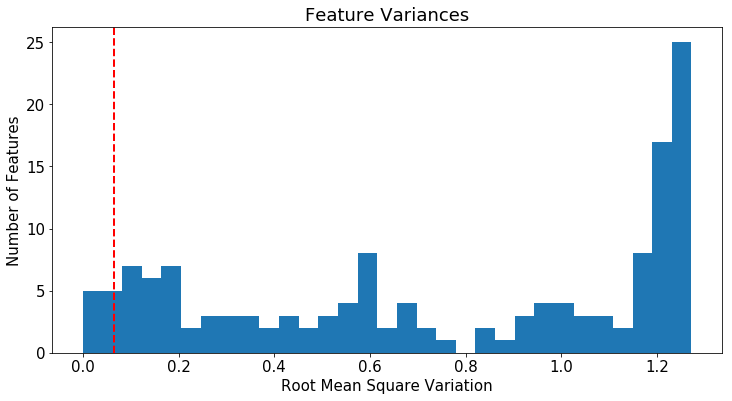

In [8]:
plt.hist(orig_rms, 31);

rms_damp = np.percentile(orig_rms, 5)
plt.axvline(rms_damp, c="r", linestyle="--")
print("Selected damping RMS", rms_damp)
plt.title("Feature Variances")
plt.xlabel("Root Mean Square Variation")
plt.ylabel("Number of Features")

Interpreting the slight pileup of features with variances close to zero as the effective noise level for all of the features I pick the 5th percentile RMS variation as a typical noise level. That will have a relatively minimal effect on the features with closer to unit variance while still ensuring that the hand full of features with either exactly 0 variation or very small variation aren't given undue weight in our analysis.

In [9]:
#normalize to near unit variance
x_norm = x/(orig_rms + rms_damp)

After rescaling the columns by their variance we can calculate the correlation as the covariance of the normalized features.

In [10]:
corr = calculate_covariance(x_norm)

Unfortunately using this strategy also means that our estimate of the correlation of each feature with itself isn't exactly equal to 1 which is something to keep an eye on.

In [11]:
max_corr = np.max(np.diag(corr))
max_corr

0.9053982212985684

# Default Settings Visualization

Now lets take a look at what the correlation and/or covariance matrices would look like as a heat map using the default settings and then apply the guidelines above one by one.

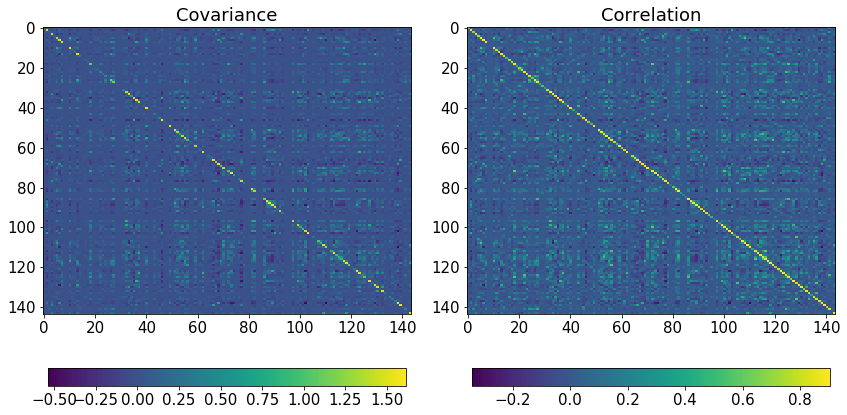

In [12]:
fig, axes = plt.subplots(1, 2)
imshow_kwargs = {}
im = axes[0].imshow(cov, **imshow_kwargs)
plt.colorbar(im, ax=axes[0], orientation="horizontal", fraction=0.05)
im = axes[1].imshow(corr, **imshow_kwargs)
plt.colorbar(im, ax=axes[1], orientation="horizontal", fraction=0.05)

axes[0].set_title("Covariance")
axes[1].set_title("Correlation")

fig.tight_layout()

We are going to be making a lot of these plots so lets collect the repeated logic into a helper function so that we can focus on the important differences between the visualizations without being bogged down in lots of lines of code.

In [13]:
def heatmap_plot(
    arr,
    imshow_kwargs=None,
    clip_percentile=99.5,
    symmetric_bounds=True,
    add_colorbar=True,
    ax=None
):
    if ax is None:
        fig, ax = plt.subplots()
    if imshow_kwargs is None:
        imshow_kwargs = {}
    if symmetric_bounds:
        vmax = np.percentile(np.abs(arr), clip_percentile)
        vmin = -vmax
    else:
        vmin, vmax = np.percentile(arr, [100-clip_percentile, clip_percentile])
    im = ax.imshow(arr, vmin=vmin, vmax=vmax, **imshow_kwargs)
    if add_colorbar:
        plt.colorbar(im, ax=ax, fraction=0.05, orientation="horizontal")
    return im

# Limited Color Map Range

It is often the case when visualizing correlation or covariance matrices that just a tiny fraction of the values in the matrix will be anywhere near the maximum or minimum values. This can mean that by default we often end up wasting a huge fraction of the visual bandwidth available to us by squeezing the bulk of the visualized values into just a hand full of the 255 available color bins. 

Instead of picking the absolute maximum or minimum value as the edges of our color map we can often greatly increase the visual bandwidth of our visualizations by clipping the color map at some high percentile of the visualized data. The degree to which this enhances the structure visible can be very striking.

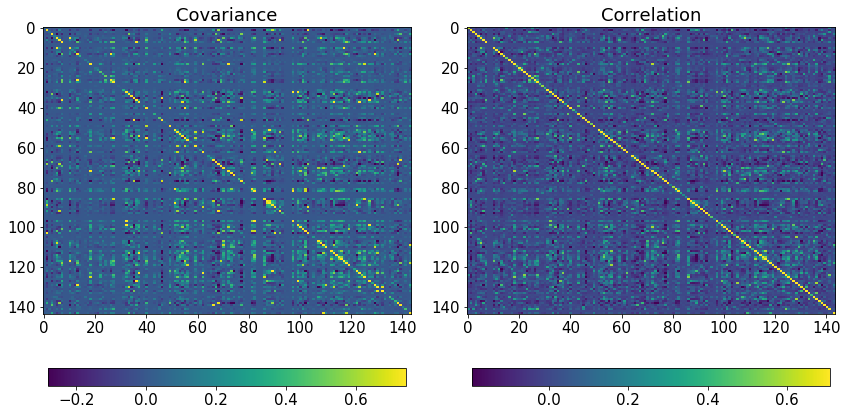

In [14]:
fig, axes = plt.subplots(1, 2)
imshow_kwargs = {}
im = heatmap_plot(cov, symmetric_bounds=False, imshow_kwargs=imshow_kwargs, ax=axes[0])
im = heatmap_plot(corr,  symmetric_bounds=False, imshow_kwargs=imshow_kwargs, ax=axes[1])

axes[0].set_title("Covariance")
axes[1].set_title("Correlation")
fig.tight_layout()

The structure is much more readily apparent now that we are focusing on the magnitude range of the bulk of the data instead of wasting the majority of our color mapping on the few points in a thousand that manage to hit the very top of the magnitude range.
Although all the correlational structure we will see in later plots is present in these ones the plots are still harder to read than they need to be. It is difficult to tell what correlations represent positive or negative values or visually estimate ratios between relative correlation strengths.

# Divergent Color Map

The Viridis color map is a generally good color map but in the peculiar case of correlation/covariance maps zero is a special value and we want to be able to instantly tell the difference between those points above zero and below zero. A diverging color map like a red/blue color map is a good way to do this. There are lots of such divergent color maps available by default in matplotlib. To see a selection of them check out this super useful visualization of different color maps. 

https://matplotlib.org/users/colormaps.html

Lets pick "coolwarm" and see how that looks.

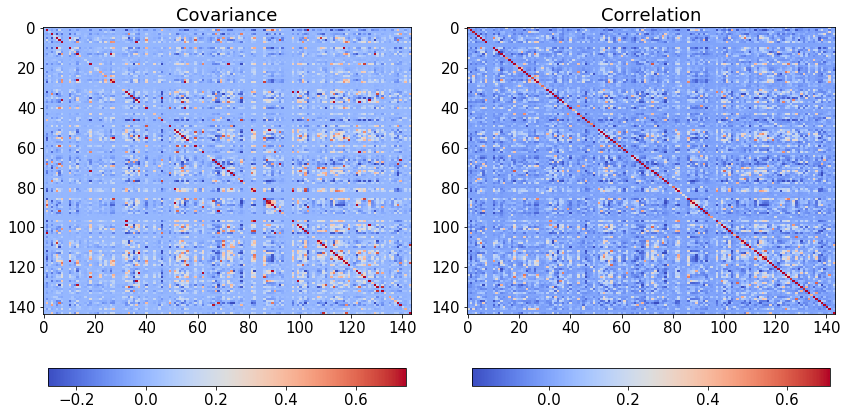

In [15]:
fig, axes = plt.subplots(1, 2)
imshow_kwargs = {"cmap":"coolwarm"}
im = heatmap_plot(cov, symmetric_bounds=False, imshow_kwargs=imshow_kwargs, ax=axes[0])
im = heatmap_plot(corr,  symmetric_bounds=False, imshow_kwargs=imshow_kwargs, ax=axes[1])

axes[0].set_title("Covariance")
axes[1].set_title("Correlation")
fig.tight_layout()

Now we can see that the features tend to be postively correlated with themselves (one should hope so). But visually we tend to group the blue and red points together with each other and because we haven't set the bounds of the color mapping so that the neutral mid color corresponds to any meaningful value this visual correlation is spurious.

# Symmetric Color Map Bounds

By setting the bounds of our color mapping symmetrically around 0 we can reap the benefits of using a divergent color map. We can immediately see when a value is positive, negative or "close" to 0.

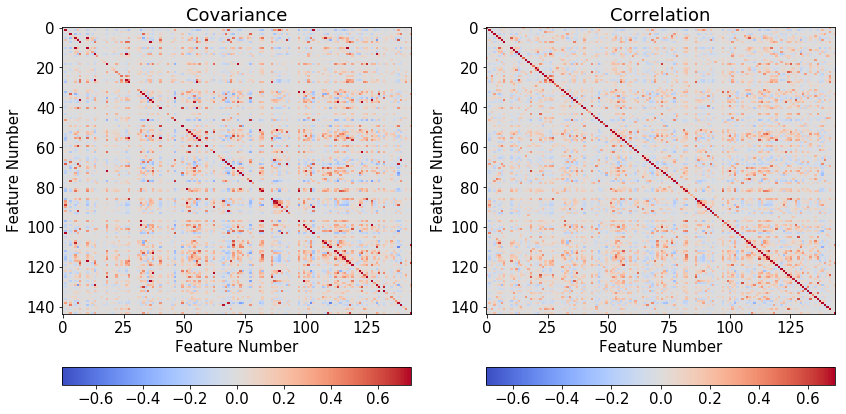

In [16]:
fig, axes = plt.subplots(1, 2)
imshow_kwargs = {"cmap":"coolwarm"}
im = heatmap_plot(cov, symmetric_bounds=True, imshow_kwargs=imshow_kwargs, ax=axes[0])
im = heatmap_plot(corr,  symmetric_bounds=True, imshow_kwargs=imshow_kwargs, ax=axes[1])

axes[0].set_title("Covariance")
axes[1].set_title("Correlation")
for ax in axes:
    ax.set_xlabel("Feature Number")
    ax.set_ylabel("Feature Number")
fig.tight_layout()

This particular color mapping makes it seem as though almost all of the features have close to zero correlation with each other. But if you pay close attention to the color bar plotted below the data you will notice that the colors change most rapidly at either end of this color map and slowest right around zero (see the plots below). The overall effect is that the points close to zero have much lower relative contrast than the points close to either end of the magnitude range. Although there are reasons why you might want to do this in general we should avoid anything that obfuscates the structure in our data. For visualizing correlations and covariances we should be especially careful about what our color maps are doing in the neighborhood of zero.

The most salient feature of a color is how bright or dark it looks and this is the only color property which we can treat as being even approximately linear. Changes in hue or saturation are very non-linear and difficult to reason about visually. Variations in the brightness of color variations will be the most important factor in determining how we perceive the structure in our visualizations (or at any rate they should if we have designed our visualization well).

Lets take a closer look at how some color maps change with respect to the the brightness of their colors for a few different prospective color maps. I took the color space conversion code from the linked matplotlib built in color map visualization page linked above. I have also included a blue/orange divergent color map with black at its mid point (about which more later).

In [17]:
from matplotlib.colors import LinearSegmentedColormap

clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
blue_orange_divergent = LinearSegmentedColormap.from_list("custom_blue_orange", clist)

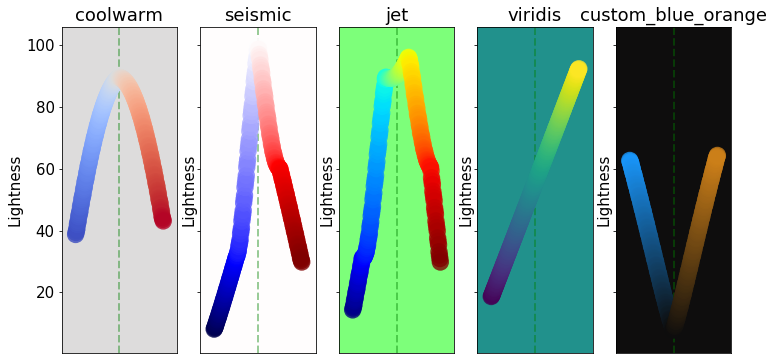

In [18]:
import matplotlib.cm as cm
from colorspacious import cspace_converter

example_cmaps = [
    cm.get_cmap("coolwarm"), 
    cm.get_cmap("seismic"),
    cm.get_cmap("jet"),
    cm.get_cmap("viridis"),
    blue_orange_divergent,
]
fig, axes = plt.subplots(1, len(example_cmaps), sharey=True, sharex=True)
axes = axes.ravel()

for cmap_idx, cmap in enumerate(example_cmaps):
    v_space = np.linspace(0, 1, 200)
    rgb_cmap_vals = cmap(v_space)[np.newaxis, :, :3]
    lab_cmap_vals = cspace_converter("sRGB1", "CAM02-UCS")(rgb_cmap_vals)

    xv = v_space
    yv = lab_cmap_vals[0, :, 0]
    axes[cmap_idx].axvline(0.5, c="g", alpha=0.4, linestyle="--", zorder=0)    
    axes[cmap_idx].scatter(
        xv, 
        yv, 
        c=v_space, s=300, 
        linewidths=0.0, 
        alpha=0.8, 
        cmap=cmap
    )
    bg_color = cmap(0.5)
    axes[cmap_idx].patch.set_facecolor(bg_color)
    axes[cmap_idx].set_title(cmap.name)
    axes[cmap_idx].set_xticks([])
    axes[cmap_idx].set_ylabel("Lightness");


If we follow the advice to always set the color map bounds symmetrically around zero then this will be the color that corresponds to 0 correlation and so will usually be the effective background color for our visualizations. The way in which the colors for each value in the color map contrasts against this background color is just as important to the look of the visualization as the way in which changes in correlation map to changes in color. So I have changed the background color of each subplot to match the midpoint color for that map.

I have included coolwarm and seismic as examples of divergent color maps and I have included jet and viridis because jet is the old default matplotlib color map (terrible though it is) and viridis is the new default matplotlib color map.

One of the first things to note is that coolwarm looks rather like the arc of a parabola in the neighborhood around 0.
This flatness in the center is what we alluded to earlier and is what is giving the correaltion heat map its washed out look. Any flat places like this in a color map where changes in the mapped value don't also correspond to proportional changes in lightness are going to cause a sort of perceptual pileup. Variations that happen to fall into these blind spots are next to invisible to us. 

Of the color maps pictured jet is the only other color map with a nearly flat lightness curve around 0. Jet in particular has other obvious problems with its multiple kinks, its ugly mid point color, and its unusually sharp brightness gradient near yellow.

Viridis is a "perceptually uniform" color map which means that the perceived difference between nearby colors is roughly the same all the way throughout the color map. As a result of that design choice there are no "dead spots" in viridis where differences in the values being mapped don't translate into proportional perceptual differences in color space. But more than just having a lack of dead spots which is shared by the seismic color map viridis has approximately linear changes in perceived brightness which makes it easy to accurately estimate visually the relative magnitudes of values color mapped by it. 

The custom blue/orange divergent color gives us a blend of the advantages of the linearity in brightness of viridis with the ability of a divergent color map to allow us to immediately differentiate between positive and negative correlations.
Additionally we have also incorporated the last of our guidelines and made the mid color a very dark grey nearly black. Bringing us to the last of our easy to meet guidelines above.


# Dark at 0 Correlation

It is more difficult to see subtle variations in color on a light background than on a darker background. Dark backgrounds make colors stand out more. Not to mention it is just generally nicer on the eyes to fill large swathes with dark colors instead of bright. 

However if you trawl through all of the built in divergent color maps in matplotlib you won't find a single suitable divergent color map which mets the criterion of having a dark color at the center. Thus the need for the custom color map above. I picked blue/orange instead of red blue because I think the resulting plots are prettier and the complementary colors contrast a little more strongly than the red/blue pairing. 

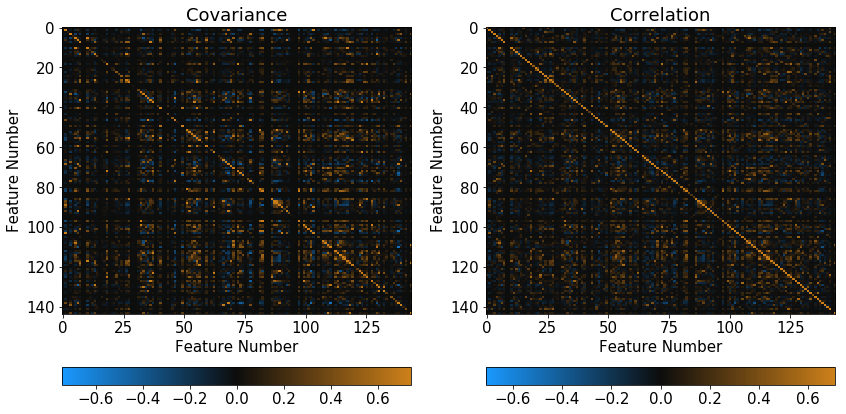

In [19]:
fig, axes = plt.subplots(1, 2)
imshow_kwargs = {"cmap":blue_orange_divergent}
im = heatmap_plot(cov, imshow_kwargs=imshow_kwargs, ax=axes[0])
im = heatmap_plot(corr,  imshow_kwargs=imshow_kwargs, ax=axes[1])

axes[0].set_title("Covariance")
axes[1].set_title("Correlation")
for ax in axes:
    ax.set_xlabel("Feature Number")
    ax.set_ylabel("Feature Number")
fig.tight_layout()

Now we are getting somewhere. This is the first heatmap in which I can clearly see the correlational structure. There are no perceptual blind spots with changes in brightness being just as large in the neighborhood around zero as any other, the differences in correlation magnitude are proportional to differences in the brightness of the associated color, positive correlations are immediately visually separated from negative, and last but not least the colors of the strongly correlated features are shown on a contrast enhancing dark background instead of an eye straining contrast destroying bright color.

# Feature Ordering

We are almost there, the last important thing to consider is how to order our features. Ordering the features so that we can best understand the correlation structure is very difficult, there is no one "right" way to do it. However there are several rather good ways of ordering the features. 

The thing we are going to do with this data set is to order the features by total variance. In general this is not a bad first thing to try but you can pick any metric you like to order the features and other choices may be apropriate depending on the purpose of your analysis. This is a very good strategy from a visualization perspective since now position within the matrix encodes some additional piece of information. Without having increased the complexity of the visualization at all we have significantly increased the informational bandwidth.

In [20]:
variance_order = np.argsort(-np.std(x, axis=0))

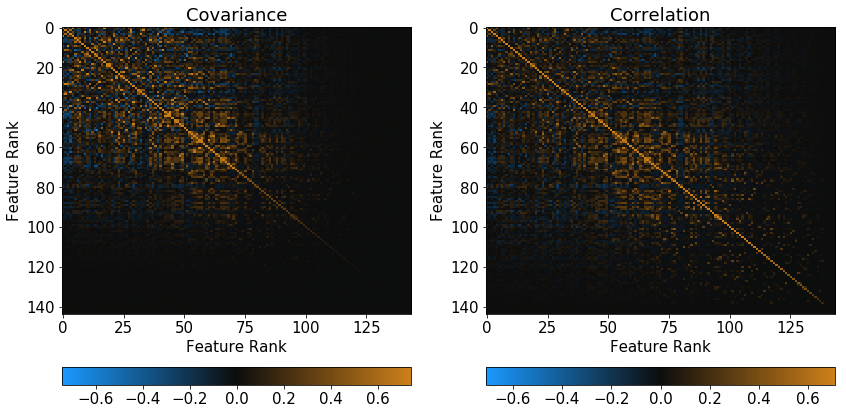

In [21]:
fig, axes = plt.subplots(1, 2)

imshow_kwargs = {"cmap":blue_orange_divergent}
ordering = variance_order

im = heatmap_plot(cov[ordering][:, ordering], imshow_kwargs=imshow_kwargs, ax=axes[0])
im = heatmap_plot(corr[ordering][:, ordering],  imshow_kwargs=imshow_kwargs, ax=axes[1])

axes[0].set_title("Covariance")
axes[1].set_title("Correlation")
for ax in axes:
    ax.set_xlabel("Feature Rank")
    ax.set_ylabel("Feature Rank")
fig.tight_layout()

This ordering cleans up the covariance matrix more than the correlation matrix after all ordering by total variance amounts to trying to collect the higher magnitude points to the upper left and that trend is clearly apparent in the resulting visualization. The correlation matrix also becomes quite a bit more visually accessible, looking more structured and less like random noise.

But even if you agree with me that the correlation matrix ordered in this way looks better that does not mean that this ordering is any more useful. So at this point we will switch gears a little bit and consider the utility of the visualization of the data correlation matrix as a tool for a purpose. You may have noticed that along with our mystery data "x" we loaded a target vector "y". This is a binary class label with approximately balanced classes. 

Lets split the data up by this target category and see if the correlation structure shows any clear differences between the categories and especially whether the difference in structure is made more clear by our visualization choices.

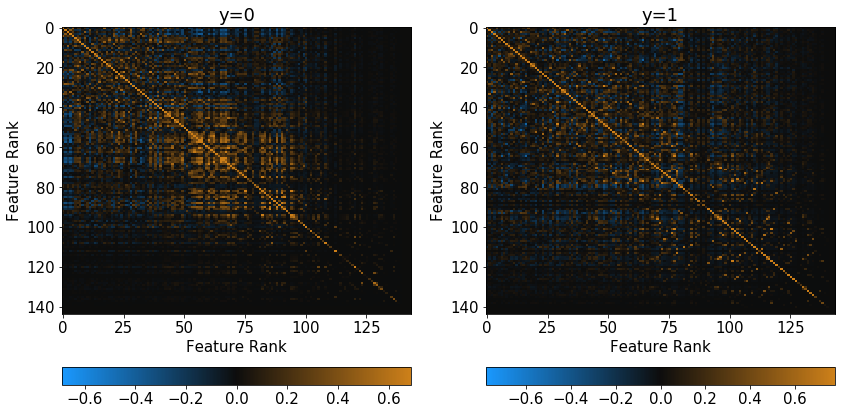

In [22]:
fig, axes = plt.subplots(1, 2)

imshow_kwargs = {"cmap":blue_orange_divergent}
ordering = variance_order

corr_neg = calculate_covariance(x_norm[y==0])
corr_pos = calculate_covariance(x_norm[y==1])

heatmap_plot(corr_neg[ordering][:, ordering], imshow_kwargs=imshow_kwargs, ax=axes[0])
heatmap_plot(corr_pos[ordering][:, ordering], imshow_kwargs=imshow_kwargs, ax=axes[1])

axes[0].set_title("y=0")
axes[1].set_title("y=1")
for ax in axes:
    ax.set_xlabel("Feature Rank")
    ax.set_ylabel("Feature Rank")
fig.tight_layout()

Note that although we have used the variance normalized features to calculate these matrices we haven't normalized to the per class variance and so these matrices are not correlation matrices but are rather covariance matrices in a scaled feature space.

I think it is clear that the structure of the covariance matrices for the two classes are dramatically different from one another. In fact if you look at the total correlation matrix above you can see that it is in fact made up as a weighted sum of these two component parts. 

# Feature Cluster Order

Simply ordering the features by some arbitrary metric worked out reasonably well in this case but that is not always so. Isn't there a better way to organize the features sho that features with similar correlational relationships end up close to each other?

A solution to this problem which is common in bioinformatics is to apply agglomerative hierarchical clustering to the features and then reorganize the feature vectors according to how they are laid out in the resuling hierarchy. Lets see how that looks.

In [23]:
#cluster the features
feature_linkage_matrix = scipy.cluster.hierarchy.linkage(corr)

We can visualize the resulting binary tree by laying out the tree one branch at a time. We have quite a bit of freedom as for how to order the children of each node but I will just use the readily available options within the scipy.cluster.hiearchy.dendrogram helper function for visualizing the tree.

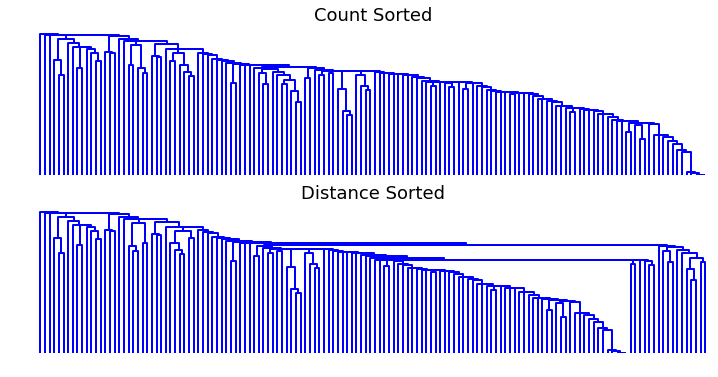

In [24]:
fig, axes = plt.subplots(2, 1)

count_sort_dendrogram = scipy.cluster.hierarchy.dendrogram(
    feature_linkage_matrix, 
    count_sort="ascending", 
    color_threshold=0,
    ax=axes[0],
)
dist_sort_dendrogram = scipy.cluster.hierarchy.dendrogram(
    feature_linkage_matrix, 
    distance_sort="ascending", 
    color_threshold=0,
    ax=axes[1]
)

axes[0].axis("off")
axes[1].axis("off")
axes[0].set_title("Count Sorted")
axes[1].set_title("Distance Sorted");

The leaves of this tree are the original features we fed into the clustering algorithm and so we can recycle the ordering of the leaves of this tree as an ordering of our features in our visualizations. Lets see how that looks.

## Dendrogram Ordering (count sorted)

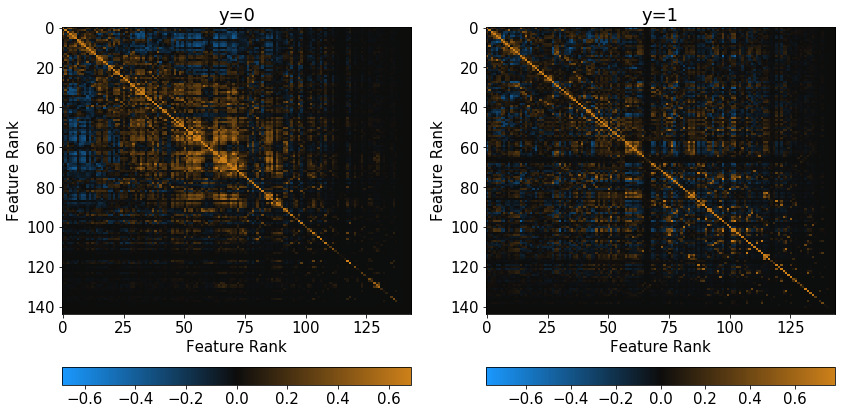

In [25]:
fig, axes = plt.subplots(1, 2)

imshow_kwargs = {"cmap":blue_orange_divergent}
ordering = count_sort_dendrogram["leaves"]

corr_neg = calculate_covariance(x_norm[y==0])
corr_pos = calculate_covariance(x_norm[y==1])

heatmap_plot(corr_neg[ordering][:, ordering], imshow_kwargs=imshow_kwargs, ax=axes[0])
heatmap_plot(corr_pos[ordering][:, ordering], imshow_kwargs=imshow_kwargs, ax=axes[1])

axes[0].set_title("y=0")
axes[1].set_title("y=1")
for ax in axes:
    ax.set_xlabel("Feature Rank")
    ax.set_ylabel("Feature Rank")
fig.tight_layout()

## Dendrogram Ordering (distance sorted)

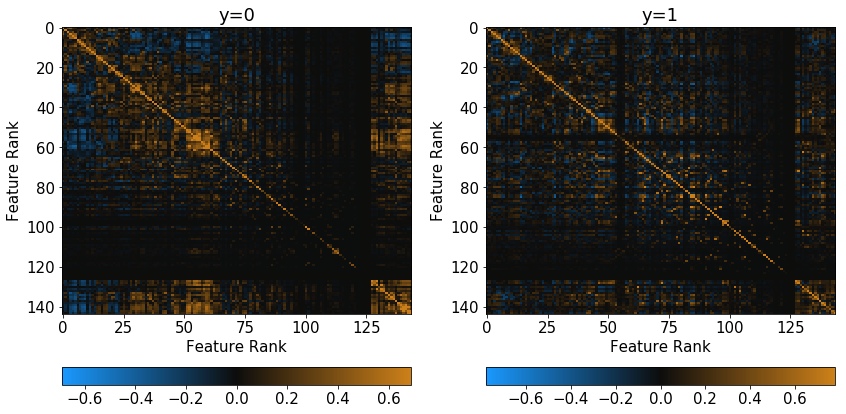

In [26]:
fig, axes = plt.subplots(1, 2)

imshow_kwargs = {"cmap":blue_orange_divergent}
ordering = dist_sort_dendrogram["leaves"]

corr_neg = calculate_covariance(x_norm[y==0])
corr_pos = calculate_covariance(x_norm[y==1])

heatmap_plot(corr_neg[ordering][:, ordering], imshow_kwargs=imshow_kwargs, ax=axes[0])
heatmap_plot(corr_pos[ordering][:, ordering], imshow_kwargs=imshow_kwargs, ax=axes[1])

axes[0].set_title("y=0")
axes[1].set_title("y=1")
for ax in axes:
    ax.set_xlabel("Feature Rank")
    ax.set_ylabel("Feature Rank")
fig.tight_layout()

I think it is difficult to say in any absolute sense which of these feature orderings is best. But certainly any of these orderings look much better than the initial random order. In general you can expect the dendrogram ordering or almost any principled ordering of your features to look better than a random ordering. 

# Side by Side Comparison

Now it is time to compare the results of the heatmaps we get from the default settings to the heatmaps we get if we follow the guidelines we have laid out in this post. We will use the count sorted dendrogram ordering for the columns because it looks slightly better to me than the other orderings.

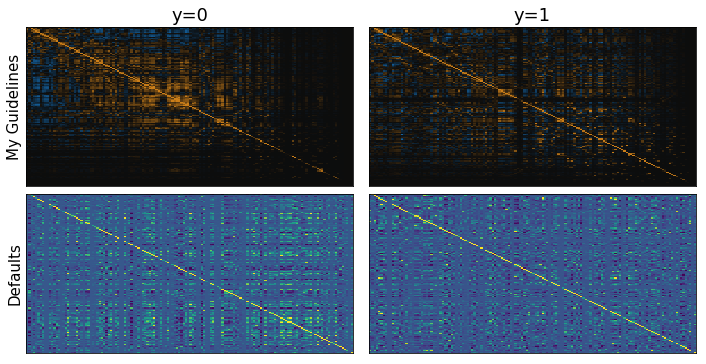

In [27]:
fig, axes = plt.subplots(2, 2, gridspec_kw={"hspace":0.05, "wspace":0.05})

ordering = count_sort_dendrogram["leaves"]
corr_neg = calculate_covariance(x_norm[y==0])
corr_pos = calculate_covariance(x_norm[y==1])

heatmap_plot(
    corr_neg[ordering][:, ordering], 
    imshow_kwargs={"cmap":blue_orange_divergent},
    add_colorbar=False,
    ax=axes[0, 0],
)
heatmap_plot(
    corr_pos[ordering][:, ordering], 
    imshow_kwargs={"cmap":blue_orange_divergent},
    add_colorbar=False,
    ax=axes[0, 1],
)

heatmap_plot(
    corr_neg, 
    imshow_kwargs={"cmap":"viridis"}, 
    symmetric_bounds=False, 
    add_colorbar=False,
    ax=axes[1, 0],
)
heatmap_plot(
    corr_pos, 
    imshow_kwargs={"cmap":"viridis"}, 
    symmetric_bounds=False,
    add_colorbar=False,
    ax=axes[1, 1],
)

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])


axes[0, 0].set_title("y=0")
axes[0, 1].set_title("y=1");

axes[0, 0].set_ylabel("My Guidelines");
axes[1, 0].set_ylabel("Defaults");

Although by looking back and forth at the heatmaps you get from the default settings you can see that the two classes have a somewhat different correlational structure it is not really readily apparent. By contrast when you look at the two different classes following the guidelines we have outlined heere the difference is immediately obvious.

# Dramatic Reveal

Now is the time to reveal what the data underlying this little exercise really is. First I will give you a little hint by noting that I have permuted the features relative to the original data set and I will show you what the correlation matrix looks like if you use the original feature ordering. 

In [28]:
r_state = np.random.RandomState(seed=89)
permute = r_state.permutation(144) #the feature permutation used to generate the data
inverse_permute = permute.argsort() # the inverse permutation to return the features to their original order

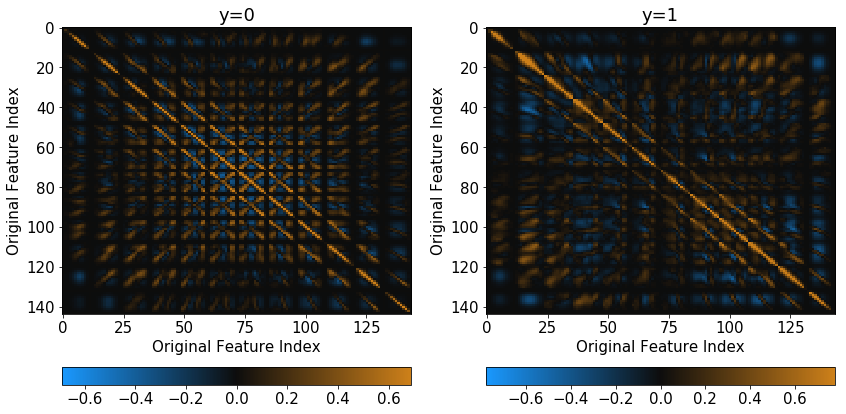

In [29]:
fig, axes = plt.subplots(1, 2)

imshow_kwargs = {"cmap":blue_orange_divergent}
ordering = inverse_permute

corr_neg = calculate_covariance(x_norm[y==0])
corr_pos = calculate_covariance(x_norm[y==1])

heatmap_plot(corr_neg[ordering][:, ordering], imshow_kwargs=imshow_kwargs, ax=axes[0])
heatmap_plot(corr_pos[ordering][:, ordering], imshow_kwargs=imshow_kwargs, ax=axes[1])

axes[0].set_title("y=0")
axes[1].set_title("y=1")
for ax in axes:
    ax.set_xlabel("Original Feature Index")
    ax.set_ylabel("Original Feature Index")

fig.tight_layout()

wow! I have to say that for me this feature ordering blows the other orderings we have experimented with out of the water in terms of aesthetics. Now both categories have coherent and visually salient structures that are clear and distinct. 

What is the source data set and why does it have such interesting looking covariance matrices? Here is the code that I used to generate the file which we loaded in at the top of this post.

In [30]:
def make_data_set(n_samples=10000, seed=89):
    import keras
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    
    flat_x = x_train[:n_samples, 3:-1:2, 3:-1:2].copy()
    n_dims = np.prod(flat_x.shape[1:])
    flat_x = flat_x.reshape((-1, n_dims))
    flat_x = flat_x/np.std(flat_x)
    
    r_state = np.random.RandomState(seed=seed)
    permute = r_state.permutation(n_dims)
    flat_x = flat_x[:, permute]
    
    target_digits = [2, 3, 5, 7]
    
    y_out = np.zeros(n_samples, dtype=int)
    for digit in target_digits:
        y_out += y_train[:n_samples] == digit
    return flat_x, y_out

make_file = False
if make_file:
    x = make_data_set()
    hf = h5py.File("example_dset.h5", "w")
    hf["x"] = x
    hf["y"] = y
    hf.close()

We have been looking at a centrally cropped part of the pixels for the first 10,000 MNIST digits and the "binary" classification is a partition of the usual 10 classes. Even if you have worked with this data a lot in the past you probably wouldn't have recognized it. It just goes to show how big of a difference feature ordering can make and how complex a problem it really is.

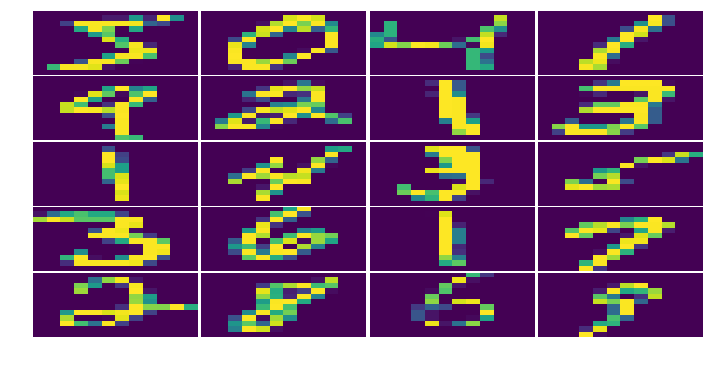

In [31]:
fig, axes = plt.subplots(5, 4, gridspec_kw={"wspace":0.02, "hspace":0.02})
axes = axes.ravel()

for i in range(len(axes)):
    axes[i].axis("off")
    axes[i].imshow(x[i, inverse_permute].reshape((12, 12)))


# Interpreting Feature Orderings In The Image Plane

Now that we know what the features are the orderings that we have been applying to the data bove have a sudden new interpretation, they are orderings of the pixels in an image! Lets take a look at how the different orderings would look in the digit image plane.

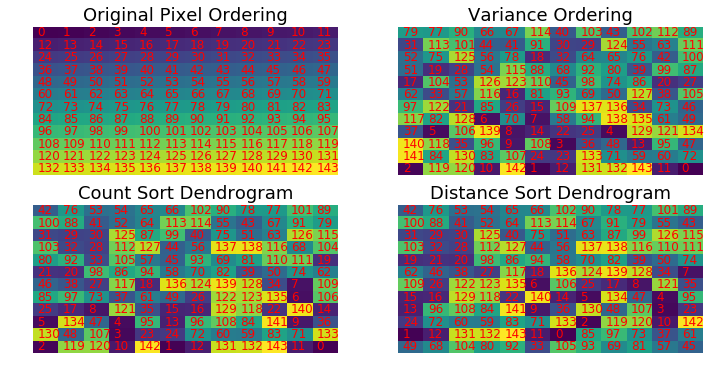

In [32]:
orderings = [
    inverse_permute,
    variance_order, 
    count_sort_dendrogram["leaves"], 
    dist_sort_dendrogram["leaves"],
]

fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

for ordering_idx, ordering in enumerate(orderings):
    pixel_indexes = permute[ordering].reshape((12, 12))
    axes[ordering_idx].imshow(pixel_indexes)
    for i in range(12):
        for j in range(12):
            axes[ordering_idx].annotate(pixel_indexes[i, j], (j-0.33, i+0.25), fontsize=12, color="r")
    
for ax in axes:
    ax.axis("Off")

axes[0].set_title("Original Pixel Ordering")
axes[1].set_title("Variance Ordering")
axes[2].set_title("Count Sort Dendrogram")
axes[3].set_title("Distance Sort Dendrogram");

Although nearby pixels in the image plane do tend to get mapped to nearby features. The 2D nature of the adjacency in the image plane means that we can't preserve closeness in both directions at once. For the original feature ordering we run along one row at a time preserving adjacency in column. 

Thinking about the features as being adjacent in 2D makes it clear why there an be no one right ordering. We could have ordered the pixels in columns instead of in rows or in diagonals or in hilbert curves etc. No matter how we do it we are going to end up making some pixels which are nearby in the image plane far away in the flattened ordering.

# Bonus Round Combined Orderings

Although this isn't general enough to qualify as a general guideline for visualizing correlation matrices I have one more neat trick that can be sometimes useful. The fact that the correlation/covariance matrices are symmetric means that we are wasting some of our visual bandwidth by displaying 2 halfs of the same matrix. Since as we have seen above the way in which we order our features can have a dramatic impact on the way our covariance matrix looks why not display 2 different orderings one above the diagonal and a different ordering below.

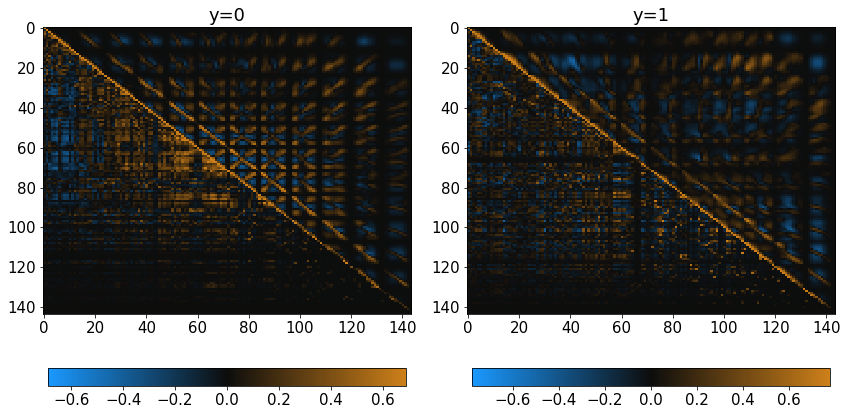

In [42]:
fig, axes = plt.subplots(1, 2)

imshow_kwargs = {"cmap":blue_orange_divergent}
order1 = inverse_permute
order2 = count_sort_dendrogram["leaves"]

corr_neg = calculate_covariance(x_norm[y==0])
corr_pos = calculate_covariance(x_norm[y==1])

neg_mat = np.zeros(corr_neg.shape)
pos_mat = np.zeros(corr_pos.shape)

idx_mat = np.arange(144**2).reshape((144, 144))
triang_mask = (idx_mat-idx_mat.transpose()) < 0

reordered = corr_neg[order1][:, order1]
neg_mat[triang_mask] = reordered[triang_mask]
reordered = corr_neg[order2][:, order2]
neg_mat[np.logical_not(triang_mask)] = reordered[np.logical_not(triang_mask)]

reordered = corr_pos[order1][:, order1]
pos_mat[triang_mask] = reordered[triang_mask]
reordered = corr_pos[order2][:, order2]
pos_mat[np.logical_not(triang_mask)] = reordered[np.logical_not(triang_mask)]

heatmap_plot(neg_mat, imshow_kwargs=imshow_kwargs, ax=axes[0])
heatmap_plot(pos_mat, imshow_kwargs=imshow_kwargs, ax=axes[1])

axes[0].set_title("y=0")
axes[1].set_title("y=1")
fig.tight_layout()

This way of combining feature orderings may not be worth the extra trouble or the extra mental burden of remembering that the rows and columns above and below the diagonal bear no relationship to each other. But the resulting visualizations are extremely appealing to me aesthetically in this particular case.

# Final Thoughts

Correlation or covariance matrices can be a nice tool to have in your exploratory visualization tool kit. Some times looking at high level relationships between lots of different variables at once reveals structure that you wouldn't have been able to spot just looking at any hand full of features by themselves. 

Comparing the look of the covariance matrices of small subgroups of data selected by different criteria of interest can be a great way to get a handle on some sorts of signals present in your data which can be invisible to other modes of analysis. For example in the plots above where we visualize covariance matrices separated by the target class it is important to note that both classes are allowed to have their own mean as a free parameter. The correlation structure that we see is a shift in variance separate from the shift in mean. 

Visualizing the shift in the mean of two groups is something that I see often but the associated shift in variance (which is often just as informative) is often not visualized because unlike the mean which is usually a vector the shift in variance is a 2D tensor and significantly harder to deal with.

If I have managed to convince you that correlation matrices can be useful multi-variate visualization tools I hope I have also managed to convince you that following the guidelines I laid out above will significantly improve the quality of those visualizations. Diverging color maps with symmetric bounds to help to distinguish between positive and negative, clip the hand full of largest and smallest values, and use a dark color at 0 to enhance color contrast.

Also although it is not as easy as the purely mechanical guidelines above remember that the ordering of the features makes a big difference and think of mixing up the columns in creative ways to see if it makes the correlation structure more clear. In the absence of some other approach use a hierarchical clustering of your columns.